In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Old Faithful and Clustering

In [2]:
faithful = pd.read_csv("data/faithful.csv")
display(faithful.head())
display(faithful.describe())

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


,eruptions,waiting
count,272.000000,272.000000
mean,3.487783,70.897059
std,1.141371,13.594974
min,1.600000,43.000000
25%,2.162750,58.000000
50%,4.000000,76.000000
75%,4.454250,82.000000
max,5.100000,96.000000


/usr/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


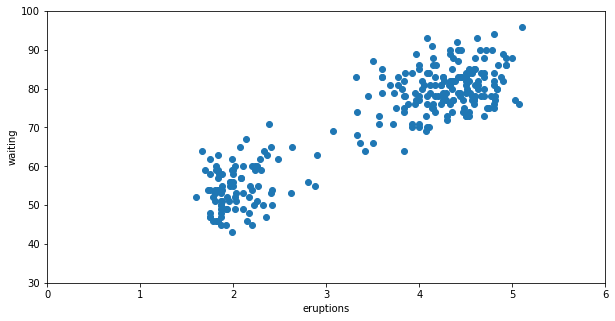

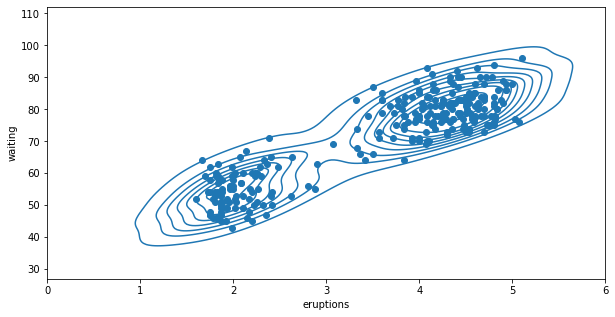

In [5]:
import seaborn as sns

plt.figure(figsize=(10,5))
plt.scatter(faithful["eruptions"], faithful["waiting"])
plt.xlabel("eruptions")
plt.ylabel("waiting")
plt.xlim(0,6)
plt.ylim(30,100)

plt.figure(figsize=(10,5))
# Contour plot
sns.kdeplot(faithful["eruptions"], faithful["waiting"])
plt.scatter(faithful["eruptions"], faithful["waiting"])
plt.xlim(0,6)
plt.show(30,100)

There are two distinct modes to the data: one with eruption values (voulmes?) of 1 to 3 and low waiting times, and a second cluster with larger eruptions and longer waiting times. Notably, there are very few eruptions in the middle.

## Review: PCA

First, we import data on different types of crime in each US state

In [6]:
USArrests = pd.read_csv("data/USArrests.csv")
USArrests['StateAbbrv'] = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT","DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ","NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC","SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
display(USArrests.head())
display(USArrests.describe())

,State,Murder,Assault,UrbanPop,Rape,StateAbbrv
0,Alabama,13.2,236,58,21.2,AL
1,Alaska,10.0,263,48,44.5,AK
2,Arizona,8.1,294,80,31.0,AZ
3,Arkansas,8.8,190,50,19.5,AR
4,California,9.0,276,91,40.6,CA


,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


The data has more dimensinons than we can easily visualize, so we use PCA to condense it. As usual, we scale the data before applying PCA. (Note that we scale everything, rather than fitting on train and carrying that scaling to future data-- we won't be using a test set here, so it's correct to use all the data to scale).

In [7]:
from sklearn import preprocessing
df = USArrests[['Murder','Assault','UrbanPop','Rape']]
scaled_df = pd.DataFrame(preprocessing.scale(df), index=USArrests['State'], columns = df.columns)

fitted_pca = PCA().fit(scaled_df)
USArrests_pca = fitted_pca.transform(scaled_df)

The biplot function plots the first two PCA components, and provides some helpful annotations

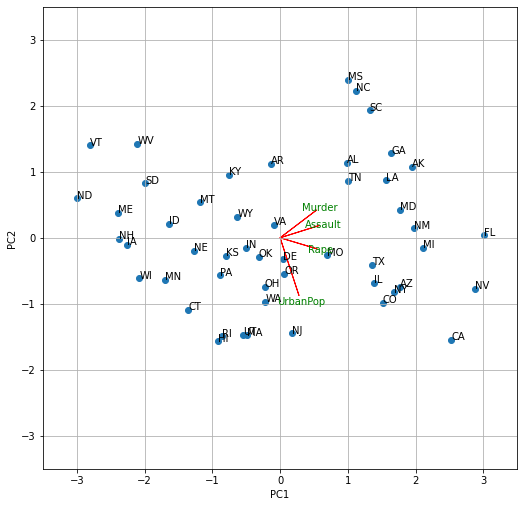

In [8]:
def biplot(scaled_data, fitted_pca, original_dim_labels, point_labels):
    
    pca_results = fitted_pca.transform(scaled_data)
    pca1_scores = pca_results[:,0]
    pca2_scores = pca_results[:,1]
    
    # plot each point in 2D post-PCA space
    plt.scatter(pca1_scores,pca2_scores)
    
    # label each point
    for i in range(len(pca1_scores)):
        plt.text(pca1_scores[i],pca2_scores[i], point_labels[i])
    
    #for each original dimension, plot what an increase of 1 in that dimension means in this space
    for i in range(fitted_pca.components_.shape[1]):
        raw_dims_delta_on_pca1 = fitted_pca.components_[0,i]
        raw_dims_delta_on_pca2 = fitted_pca.components_[1,i]
        plt.arrow(0, 0, raw_dims_delta_on_pca1, raw_dims_delta_on_pca2 ,color = 'r',alpha = 1)
        plt.text(raw_dims_delta_on_pca1*1.1, raw_dims_delta_on_pca2*1.1, original_dim_labels[i], color = 'g', ha = 'center', va = 'center')

plt.figure(figsize=(8.5,8.5))
plt.xlim(-3.5,3.5)
plt.ylim(-3.5,3.5)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

biplot(scaled_df, fitted_pca, 
       original_dim_labels=scaled_df.columns, 
       point_labels=USArrests['StateAbbrv'])

The red arrows and green text give us a sense of direction. If any state had 'murder' increase by one (scaled) unit, it would move in the direction of the 'murder' line by that amount. An increase by one (scaled) unit of both 'murder' and 'Urban Pop' would apply both moves.

We can also make inferrences about what combination of crimes and population puts California at its observed point.

## Extra: Variance Captured
As usual, we want to know how what proportion of the variance each PC captures

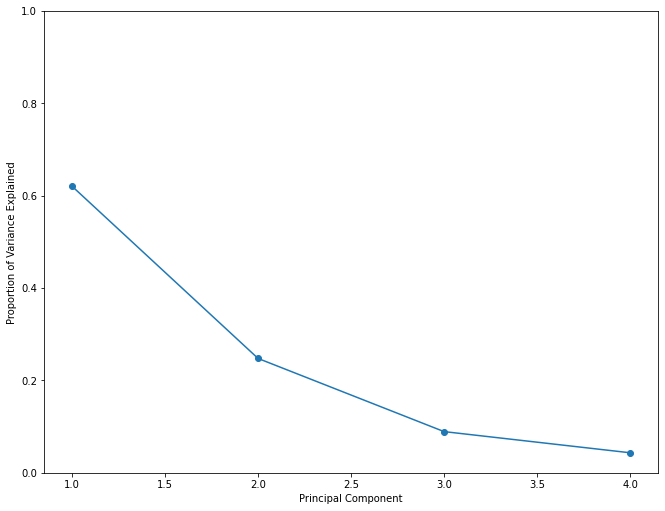

Proportion of variance explained by each PC:
[0.62006039 0.24744129 0.0891408  0.04335752]


In [9]:
plt.figure(figsize=(11,8.5))
plt.plot(range(1,5),fitted_pca.explained_variance_ratio_,"-o")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.ylim(0,1)
plt.show()

print("Proportion of variance explained by each PC:")
print(fitted_pca.explained_variance_ratio_)

Even more usefully, we can plot how much of the total variation we'd capture by using N PCs. The PCA-2 plot above has 86.7% of the total variance.

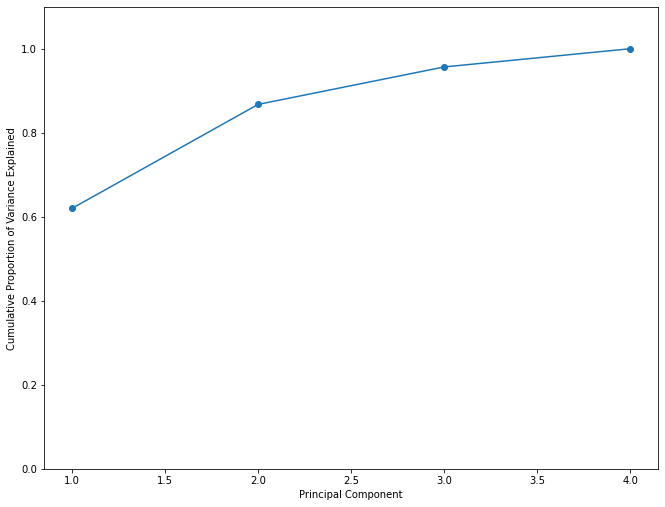

Total variance capturted when using N PCA components:
[0.62006039 0.86750168 0.95664248 1.        ]


In [11]:
plt.figure(figsize=(11,8.5))
plt.plot(range(1,5),np.cumsum(fitted_pca.explained_variance_ratio_),"-o")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Proportion of Variance Explained")
plt.ylim(0,1.1)
plt.show()

print("Total variance capturted when using N PCA components:")
print(np.cumsum(fitted_pca.explained_variance_ratio_))

# Scaling and Distances
Returning to the arrest/crime data, we again inspect the data and its PCA plot

In [12]:
np.random.seed(123)
arrests_sample = USArrests.sample(6)
arrests_sample

,State,Murder,Assault,UrbanPop,Rape,StateAbbrv
10,Hawaii,5.3,46,83,20.2,HI
13,Indiana,7.2,113,65,21.0,IN
30,New Mexico,11.4,285,70,32.1,NM
46,Washington,4.0,145,73,26.2,WA
18,Maine,2.1,83,51,7.8,ME
0,Alabama,13.2,236,58,21.2,AL


In [13]:
np.random.seed(123)
np.round(scaled_df.sample(6),2)

,Murder,Assault,UrbanPop,Rape
State,,,,
Hawaii,-0.58,-1.51,1.22,-0.11
Indiana,-0.14,-0.70,-0.04,-0.03
New Mexico,0.84,1.38,0.31,1.17
Washington,-0.88,-0.31,0.52,0.54
Maine,-1.32,-1.06,-1.01,-1.45
Alabama,1.26,0.79,-0.53,-0.00


## Distances
One of the key ideas in clustering is the distance or disimilarity between points. Euclidean distance is common, though one is free to define domain-specific measures of how similar/distant two observations are.

In [15]:
from scipy.spatial.distance import pdist # computes the distances between all pairs of data points 
from scipy.spatial.distance import squareform # turns the result into a numpy array

The `pdist` function computes the distances between all pairs of data points (which can be quite expensive for large data). `squareform` turns the result into a numpy array (the raw format avoids storing redundant values)

The distances between a handful of states are shown below. Hawaii and Indiana are relatively similar on these variables, while Maine and New Mexico are relatively different.

In [16]:
dist_eucl = pdist(scaled_df,metric="euclidean")
distances = pd.DataFrame(squareform(dist_eucl), index=USArrests["State"].values, columns=USArrests["State"].values)

sample_distances = distances.loc[arrests_sample["State"], arrests_sample["State"]]
sample_distances

,Hawaii,Indiana,New Mexico,Washington,Maine,Alabama
Hawaii,0.000000,1.561769,3.586656,1.560979,2.743631,3.422932
Indiana,1.561769,0.000000,2.617305,1.152154,2.124266,2.097219
New Mexico,3.586656,2.617305,0.000000,2.504780,4.390177,1.615635
Washington,1.560979,1.152154,2.504780,0.000000,2.655948,2.675068
Maine,2.743631,2.124266,4.390177,2.655948,0.000000,3.520494
Alabama,3.422932,2.097219,1.615635,2.675068,3.520494,0.000000


For visualization, we can make a heatmap of the sample state's distances

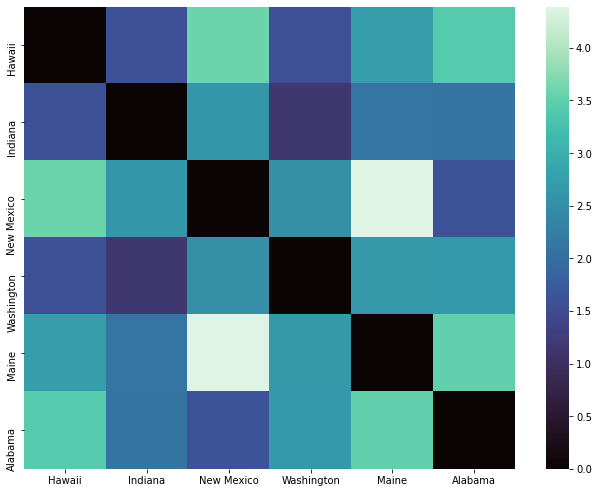

In [17]:
plt.figure(figsize=(11,8.5))
sns.heatmap(sample_distances,cmap="mako")
plt.show()

We can likewise heatmap all the states.

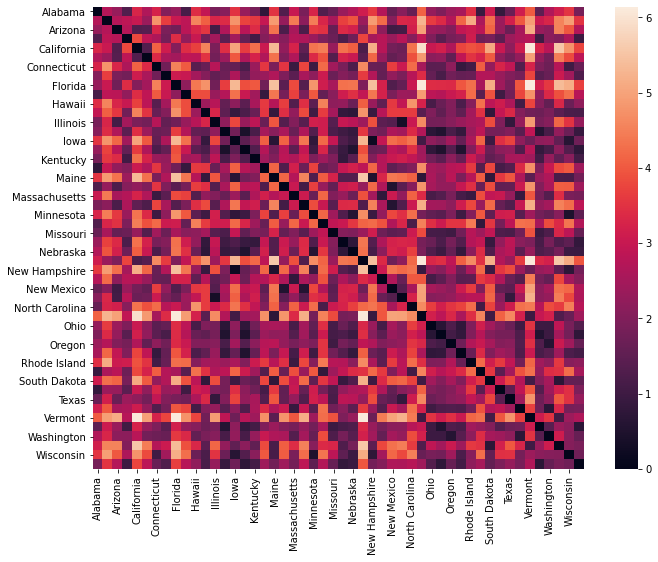

In [18]:
import seaborn as sns

plt.figure(figsize=(11,8.5))
sns.heatmap(distances)
plt.show()

# Kmeans
Kmeans is a classical, workhorse clustering algorithm, and a common place to start. It assumes there are K centers and, starting from random guesses, algorithmically improves its guess about where the centers must be.

In [23]:
from sklearn.cluster import KMeans

#random_state parameter sets seed for random number generation
# It creates 3 clusters where each cluster contains each predictor
# This means that each predictor is places in 1 of these clusters 
arrests_km = KMeans(n_clusters=3,n_init=25,random_state=123).fit(scaled_df)

# This shows the cetroids per predictor per cluster
arrests_km.cluster_centers_

array([[-0.88515915, -1.0213324 , -0.94990286, -0.92016524],
       [ 1.01513667,  1.02412028,  0.19959126,  0.85556386],
       [-0.49440658, -0.3864845 ,  0.58167593, -0.26431024]])

We can read off where the 3 cluster centers are. (The value 3 is chosen arbitratially- soon we'll see how to tell what number of clusters seems to work best)

In [24]:
pd.DataFrame(arrests_km.cluster_centers_,columns=['Murder','Assault','UrbanPop','Rape'])

,Murder,Assault,UrbanPop,Rape
0,-0.885159,-1.021332,-0.949903,-0.920165
1,1.015137,1.024120,0.199591,0.855564
2,-0.494407,-0.386484,0.581676,-0.264310


The .lables_ tell us which cluster each point was assigned to

In [25]:
scaled_df_cluster = scaled_df.copy()
scaled_df_cluster['Cluster'] = arrests_km.labels_
scaled_df_cluster.head()

,Murder,Assault,UrbanPop,Rape,Cluster
State,,,,,
Alabama,1.255179,0.790787,-0.526195,-0.003451,1
Alaska,0.513019,1.118060,-1.224067,2.509424,1
Arizona,0.072361,1.493817,1.009122,1.053466,1
Arkansas,0.234708,0.233212,-1.084492,-0.186794,0
California,0.281093,1.275635,1.776781,2.088814,1


The mean of the points in each cluster is the cluster center found by K-means

In [26]:
scaled_df_cluster.groupby('Cluster').mean()

,Murder,Assault,UrbanPop,Rape
Cluster,,,,
0,-0.885159,-1.021332,-0.949903,-0.920165
1,1.015137,1.024120,0.199591,0.855564
2,-0.494407,-0.386484,0.581676,-0.264310


## Silhouette Plots
Silhouette plots give rich information on the quality of a clustering

In [27]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
#modified code from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silplot(X, cluster_labels, clusterer, pointlabels=None):
    n_clusters = clusterer.n_clusters
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(11,8.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = ", n_clusters,
          ", the average silhouette_score is ", silhouette_avg,".",sep="")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(0,n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    
    # axes will be first 2 PCA components
    pca = PCA(n_components=2).fit(X)
    X_pca = pca.transform(X) 
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', s=200, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    xs = X_pca[:, 0]
    ys = X_pca[:, 1]    

    
    if pointlabels is not None:
        for i in range(len(xs)):
            plt.text(xs[i],ys[i],pointlabels[i])

    # Labeling the clusters (transform to PCA space for plotting)
    centers = pca.transform(clusterer.cluster_centers_)
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

For n_clusters = 4, the average silhouette_score is 0.33968891433344395.


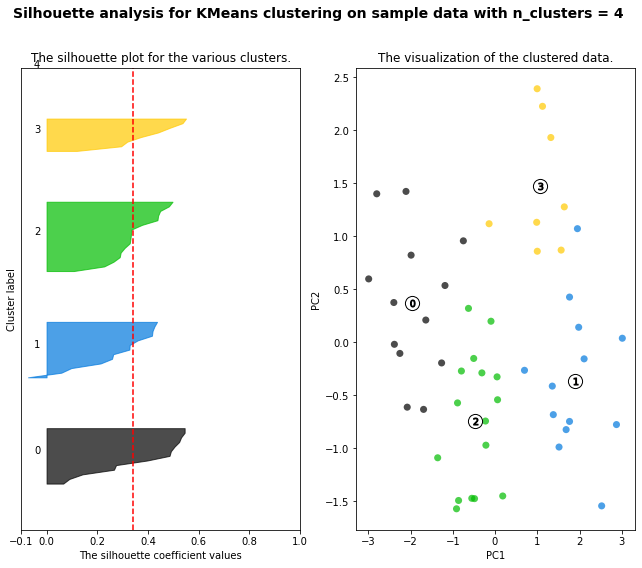

In [28]:
fitted_km = KMeans(n_clusters=4,n_init=25,random_state=123).fit(scaled_df)
cluster_labels = fitted_km.labels_

silplot(scaled_df.values, cluster_labels, fitted_km)

In [30]:
# Objects with negative silhouette -> Should be in the yellow one
sil = silhouette_samples(scaled_df, fitted_km.labels_)

USArrests.loc[sil<=0,:]

,State,Murder,Assault,UrbanPop,Rape,StateAbbrv
24,Missouri,9.0,178,70,28.2,MO


## Elbow plots

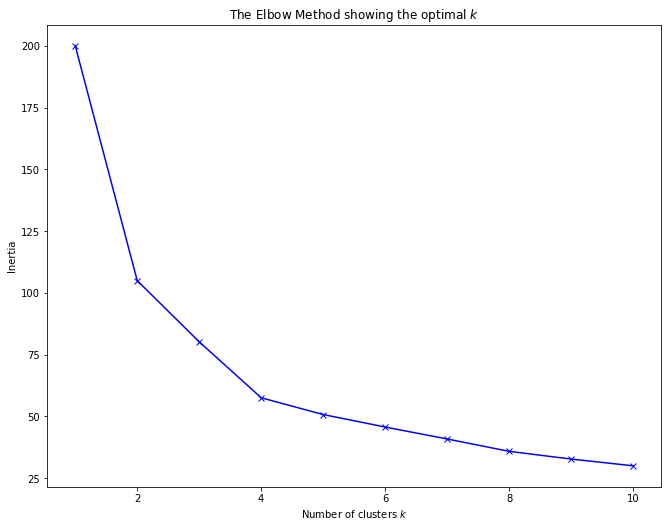

In [31]:
wss = []
for i in range(1,11):
    fitx = KMeans(n_clusters=i, init='random', n_init=5, random_state=109).fit(scaled_df)
    wss.append(fitx.inertia_)

plt.figure(figsize=(11,8.5))
plt.plot(range(1,11), wss, 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal $k$')
plt.show()

# Silhouette Score

Optimized at 2 clusters


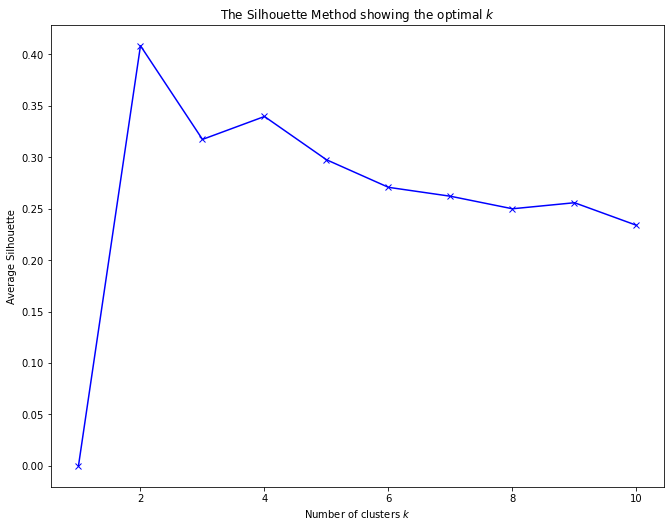

In [32]:
from sklearn.metrics import silhouette_score

# Score is 0 because it has no distance with itself
scores = [0]  # silhouette score for 1 cluster
for i in range(2,11):
    fitx = KMeans(n_clusters=i, init='random', n_init=5, random_state=109).fit(scaled_df)
    score = silhouette_score(scaled_df, fitx.labels_)
    scores.append(score)

print("Optimized at", max(range(len(scores)), key=scores.__getitem__)+1, "clusters")
    
plt.figure(figsize=(11,8.5))
plt.plot(range(1,11), np.array(scores), 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Average Silhouette')
plt.title('The Silhouette Method showing the optimal $k$')
plt.show()

# Gap Statistic

In [33]:
# need to install library 'gap-stat'
from gap_statistic import OptimalK

gs_obj = OptimalK()

n_clusters = gs_obj(scaled_df.values, n_refs=50, cluster_array=np.arange(1, 15))
print('Optimal clusters: ', n_clusters)

ModuleNotFoundError: No module named 'gap_statistic'

In [34]:
gs_obj.gap_df.head()

NameError: name 'gs_obj' is not defined

In [35]:
gs_obj.plot_results()

NameError: name 'gs_obj' is not defined

# Hierarchical Clustering
K-means is a very 'hard' clustering: points belong to exactly one cluster, no matter what. A hierarchical clustering creates a nesting of clusters as existing clusters are merged or split. 

Dendograms (literally: branch graphs) can show the pattern of splits/merges.

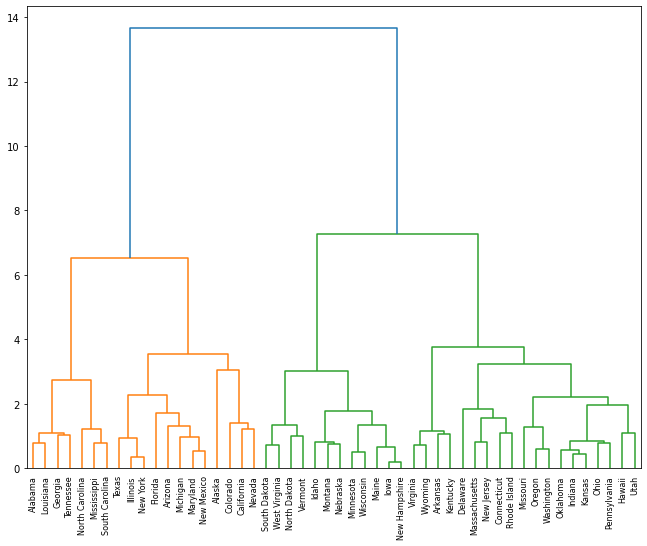

In [36]:
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist

plt.figure(figsize=(11,8.5))
dist_mat = pdist(scaled_df, metric="euclidean")
ward_data = hac.ward(dist_mat)

hac.dendrogram(ward_data, labels=USArrests["State"].values);
plt.show()

# DBSCAN
DBSCAN is a more modern clustering approach that allows points to not be part of any cluster, and determines the number of clusters by itself.

First, let's look at out data

In [37]:
multishapes = pd.read_csv("data/multishapes.csv")
ms = multishapes[['x','y']]

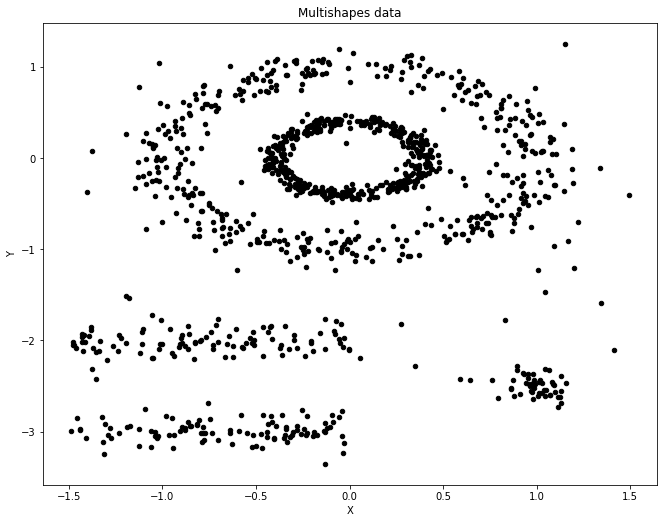

In [38]:
msplot = ms.plot.scatter(x='x',y='y',c='Black',title="Multishapes data",figsize=(11,8.5))
msplot.set_xlabel("X")
msplot.set_ylabel("Y")
plt.show()

To the eye, there's a pretty clear structure to the data

However, K-means struggles to find a good clustering

In [39]:
shape_km = KMeans(n_clusters=5,n_init=25,random_state=123).fit(ms)

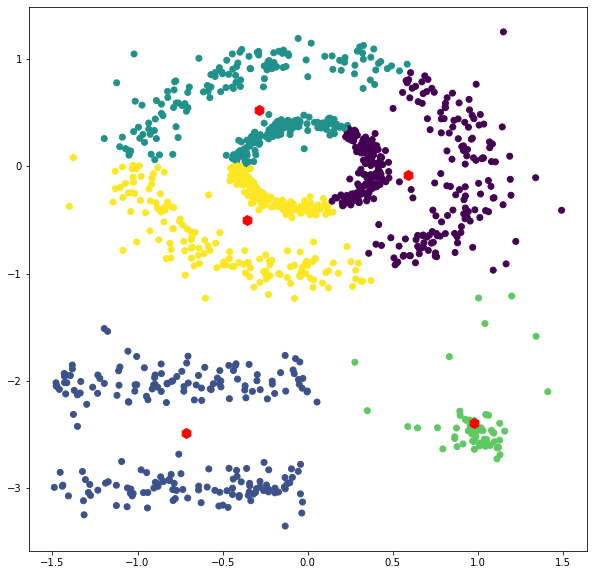

In [40]:
plt.figure(figsize=(10,10))
plt.scatter(ms['x'],ms['y'], c=shape_km.labels_);
plt.scatter(shape_km.cluster_centers_[:,0],shape_km.cluster_centers_[:,1], c='r', marker='h', s=100); 
#todo: labels? different markers?

DB Scan uses a handful of parameters, including the number of neighbors a point must have to be considered 'core' (`min_samples`) and the distance within which neighbors must fall (`epsilon`). Most reasonable values of min_samples yeild the same results, but tuning epsilon is important.

The function below implement's the authors suggestion for setting epsilon: look at the nearest-neighbor distances and find a level where they begin to grow rapidly.

In [41]:
from sklearn.neighbors import NearestNeighbors

def plot_epsilon(df, min_samples):

    fitted_neigbors = NearestNeighbors(n_neighbors=min_samples).fit(df)
    distances, indices = fitted_neigbors.kneighbors(df)
    
    dist_to_nth_nearest_neighbor = distances[:,-1]
    plt.plot(np.sort(dist_to_nth_nearest_neighbor))
    plt.xlabel("Index\n(sorted by increasing distances)")
    plt.ylabel("{}-NN Distance (epsilon)".format(min_samples-1))
    plt.tick_params(right=True, labelright=True)

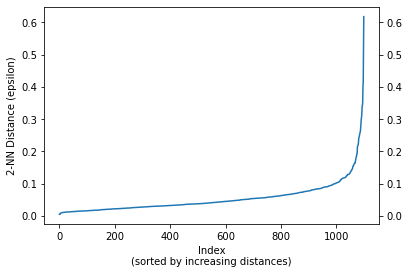

In [42]:
plot_epsilon(ms, 3)

The major slope occurs around eps=0.15 when min_samples set to 3.

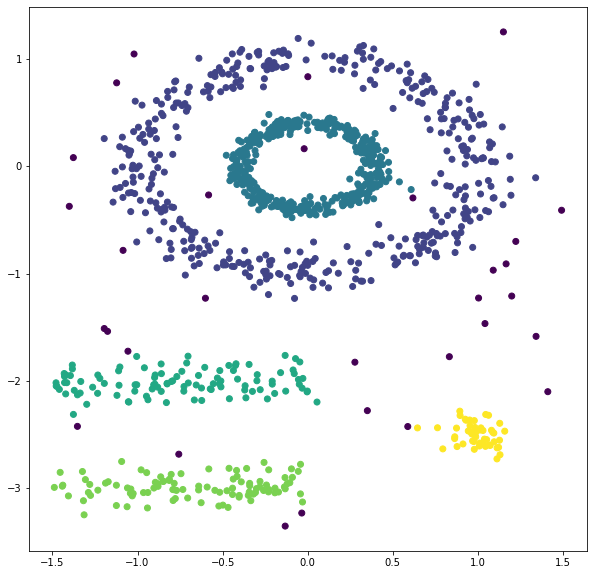

In [44]:
from sklearn.cluster import DBSCAN

fitted_dbscan = DBSCAN(eps=0.15).fit(ms)

plt.figure(figsize=(10,10))
plt.scatter(ms['x'],ms['y'], c=fitted_dbscan.labels_);

We see good results with the suggested epsilon. A lower epsilon (0.12) won't quite merge all the clustersWe 

## DBSCAN on crime data

Returning to the crime data, let's tune epsilon and see what clusters are returned

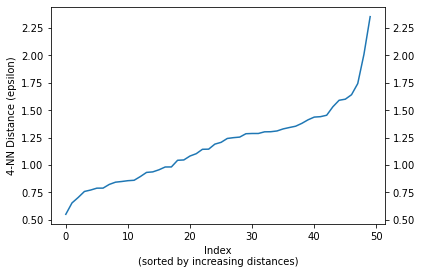

In [45]:
plot_epsilon(scaled_df, 5)

The optimal value is either around 1.4 to 1.6.  Choosing one versus the other does not result in different clusterings.

In [46]:
fitted_dbscan = DBSCAN(eps=1.4,min_samples=5).fit(scaled_df)
fitted_dbscan.labels_

array([ 0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

At this `epsilon` and `min_samples`, all but one state are included in cluster 0. The remaining point (Alaska) is not part of any cluster.  DBSCAN is not particularly effective using this data set.